In [21]:
from utils_article import european_option_delta, clamp, generate_geometric_brownian_motion_article
from utils_article import MultiLayerPerceptron, NoTransactionBandNet, FeedForwardNet

from utils_andersen import noncentral_chisquare, generate_cir, generate_heston

In [4]:
import numpy as np
import torch
import typing

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn

import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

In [5]:
seaborn.set_style("whitegrid")
torch.manual_seed(42)

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
else: DEVICE = torch.device('cpu')

In [6]:
N_PATHS = 10000
N_EPOCHS = 200

T = 1.0 
dt = T / N_EPOCHS
S0 = 100.0 
mu = 0.05 
sigma = 0.2 

In [7]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

In [8]:
def european_option_payoff(prices, strike=1.0):
    return fn.relu(prices[-1, :] - strike)

In [9]:
def generate_geometric_brownian_motion(n_paths: int, n_steps: int, init_state,
                                       sigma: float = 0.2, mu: float = 0.0, dt: float = 1 / 250, r = 0.05, method = "Milstein"):
  torch.manual_seed(123)
  
  if (method == "Milstein"):
      S = torch.zeros(n_paths, n_steps)  
      S[:, 0] = torch.transpose(init_state, 0, 1)

      Z = torch.randn(n_paths, n_steps)
      
      for t in range(1, n_steps):
          S[:, t] = S[:, t-1] + mu*S[:, t-1]*dt + sigma*S[:, t-1]*np.sqrt(dt)*Z[:, t] + 0.5*sigma**2*S[:, t-1]*(Z[:, t]**2-1)*dt

  if (method == "euler"):
      n_steps -= 1
      S = torch.zeros((n_paths, n_steps +1), dtype=torch.float32)
      S[:, 0] = torch.transpose(init_state, 0, 1)

      dW = torch.normal(mean=torch.zeros((n_paths, n_steps)), std=torch.ones((n_paths, n_steps)))
      for t in range(1, n_steps + 1):      
          S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW[:, t-1])

  return S

For simulating GBM we will use Milstein method. It is more accurate than Eulers as it takes into account the second-order terms in the stochastic differential equation.

$$Y_{n+1} = Y_n + f(Y_n,t_n)\Delta t + g(Y_n,t_n)\Delta W_n + \frac{1}{2} g(Y_n,t_n) g'(Y_n,t_n)((\Delta W_n)^2 - \Delta t) $$

where $Y_n$ is the approximate solution at time $t_n$, $ \mbox{ }f(Y_n,t_n) \mbox{ }$ and $g(Y_n,t_n) \mbox{ }$ are functions of $Y_n$ and $t_n$, $\Delta t = t_{n+1} - t_n$ is the time step, $\Delta W_n = W_{t_{n+1}} - W_{t_n}$ is the Wiener increment, and $g'(Y_n,t_n)$ is the partial derivative of $g$ with respect to $Y_n$.

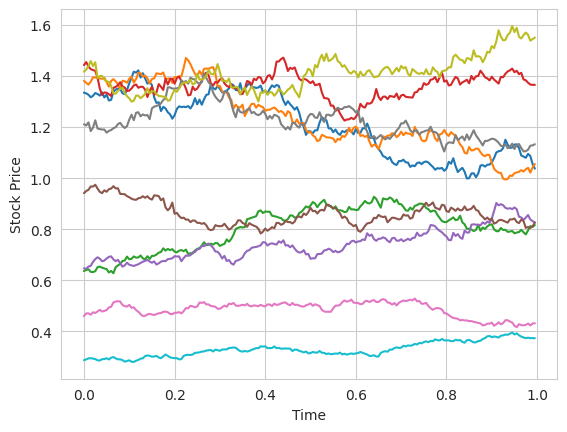

In [10]:
init_s = (10 + (150-10)*torch.rand(N_PATHS, 1))/100
S = generate_geometric_brownian_motion(n_paths = N_PATHS, n_steps = N_EPOCHS, init_state = init_s, method = "Milstein")

plt.plot(torch.arange(0, T, dt), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

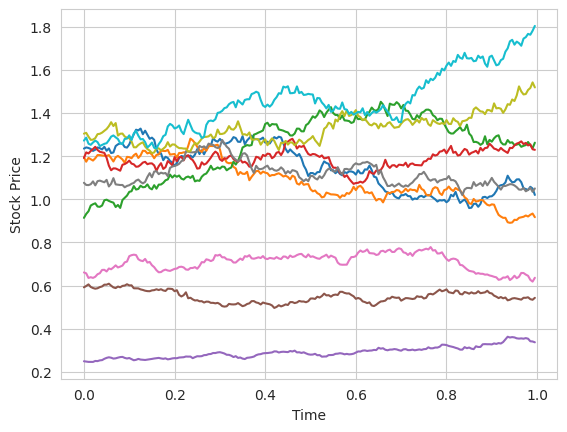

In [11]:
init_s = (10 + (150-10)*torch.rand(N_PATHS, 1))/100
S = generate_geometric_brownian_motion(n_paths = N_PATHS, n_steps = N_EPOCHS, init_state = init_s, method = "euler")

plt.plot(torch.arange(0, T, dt), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

In [12]:
def Heston_simulation(n_paths: int, n_steps: int, init_state, r= 0.05, kappa = 1.5, theta = 0.04, sigma = 0.3, rho = 0.8, dt = 1/ 250):

    S = torch.zeros((n_paths, n_steps+1))
    v = torch.zeros((n_paths, n_steps+1))
    S[:, 0] = torch.transpose(init_state, 0, 1)
    v[:, 0] = theta

    
    dW1 = np.random.normal(size=(n_paths, n_steps))
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(size=(n_paths, n_steps))

    for i in range(1, n_steps+1):
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * v[:, i-1]) * dt + np.sqrt(v[:, i-1] * dt) * dW1[:, i-1])
        v[:, i] = np.maximum(0, v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + sigma * np.sqrt(v[:, i-1] * dt) * dW2[:, i-1])

    return S[:, 1:]

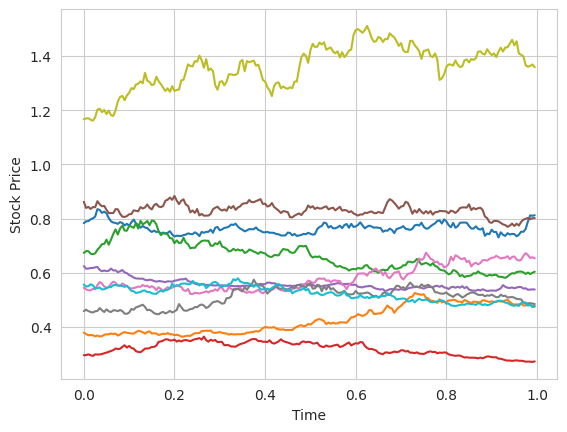

In [13]:
init_s = (10 + (150-10)*torch.rand(N_PATHS, 1))/100
S = Heston_simulation(n_paths = N_PATHS, n_steps = N_EPOCHS, init_state = init_s)

plt.plot(torch.arange(0, T, dt), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

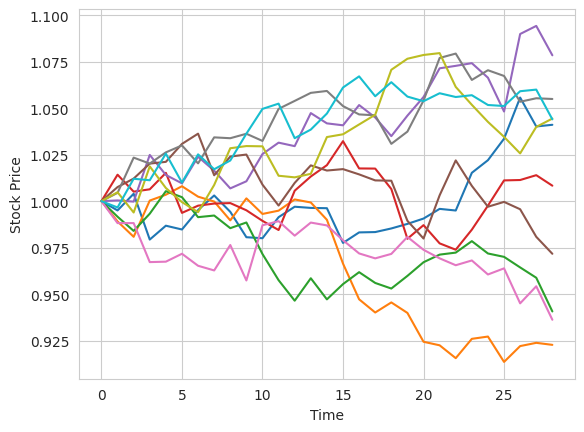

In [14]:
S = generate_geometric_brownian_motion_article(n_paths = N_PATHS, maturity=30 / 365, dt=1 / 365, volatility=0.2, device=DEVICE).T

plt.plot(torch.arange(0, 29, 1), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

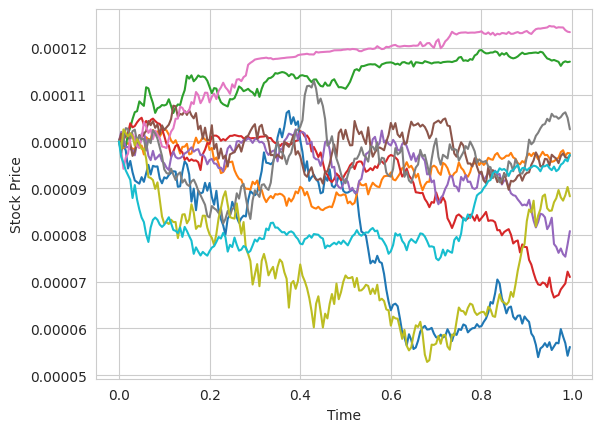

In [32]:
init_s = torch.full((N_PATHS, ), 0.0001, dtype=torch.float32) 
init_v = torch.full((N_PATHS, ), 0.066, dtype=torch.float32) 

S = generate_heston(n_paths = N_PATHS, n_steps = N_EPOCHS - 1, dt = 1 / 250, init_state_price = init_s, init_state_var = init_v, kappa = 1.2, theta = 0.066, eps = 0.592, rho = -0.65, drift = 0)[0]

plt.plot(torch.arange(0, T, dt), S[:10].T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

In [38]:
from sklearn.decomposition import PCA

def compute_profit_and_loss(hedging_model, payoff, cost, n_paths = N_PATHS, maturity = 30 / 365, dt = 1 / 365, 
                            volatility = 0.2, r = 0.05, kappa = 1.5, theta = 0.04, sigma = 0.3, rho = 0.8, _n_components = 10, method = "article", init = ["constant", 0.0001]):
   
    if init[0] == "constant":
        # To set the same init value:
        init_s = torch.full((n_paths, 1), init[1], dtype=torch.float32) 
    if init[0] == "random":
        # Random init:
        init_s = init[1] * torch.rand(n_paths, 1)
        
    if method == "Milstein":
        prices = generate_geometric_brownian_motion(n_paths, n_steps = int (maturity / dt), dt=dt, sigma = volatility, init_state = init_s, method = "Milstein")
    if method == "euler":
        prices = generate_geometric_brownian_motion(n_paths, n_steps = int (maturity / dt), dt=dt, sigma = volatility, init_state = init_s, method = "euler")
    if method == "article":
        prices = generate_geometric_brownian_motion_article(n_paths, maturity=maturity, dt=dt, volatility=volatility, device=DEVICE).T
    if method == "Heston":
        prices = Heston_simulation(n_paths, n_steps = int (maturity / dt), init_state = init_s, r = r, kappa = kappa, theta = theta, sigma = sigma, rho = rho, dt = dt)
    if method == "Andersen":
        init_s = init[1] * torch.ones(n_paths, dtype=torch.double)
        init_v = volatility * torch.ones(n_paths, dtype=torch.double) 
        prices = generate_heston(n_paths = N_PATHS, n_steps = int (maturity / dt), dt = dt, init_state_price = init_s, init_state_var = init_v, kappa = kappa, theta = theta, eps = sigma, rho = rho, drift = 0)[0]

    
    prices = prices.T

    hedge = torch.zeros_like(prices[:1]).reshape(-1)
    pnl = 0

    pca = PCA(n_components = _n_components)
    pca.fit(prices)
    transformed = torch.tensor(pca.transform(prices))
    prices_pca = torch.tensor(pca.inverse_transform(transformed))
    result_pnl =[]
    

    for i in [prices, prices_pca]:   
        hedge = torch.zeros_like(i[:1]).reshape(-1)
        pnl = 0
        
        for n in range(i.shape[0] - 1):
            
            x_log_moneyness = i[n, :, None].log()
            x_time_expiry = torch.full_like(x_log_moneyness, maturity - n * dt)
            x_volatility = torch.full_like(x_log_moneyness, volatility)
            x = torch.cat([x_log_moneyness, x_time_expiry, x_volatility], 1)
        
            prev_hedge = hedge
            
            hedge = hedging_model(x, prev_hedge)

            pnl += hedge * (i[n + 1] - i[n])
            pnl -= cost * torch.abs(hedge - prev_hedge) * i[n]

        pnl -= payoff(i)
        result_pnl.append(pnl)
    return result_pnl

In [16]:
torch.manual_seed(42)
model_ntb = NoTransactionBandNet().to(DEVICE)
torch.manual_seed(42)
model_ffn = FeedForwardNet().to(DEVICE)

def plot (_method = "article", _init = ["constant", 0.0001]):

    torch.manual_seed(42)
    pnl_ntb, pnl_ntb_pca = compute_profit_and_loss(model_ntb, european_option_payoff, cost=1e-3, method = _method, init = _init)
    torch.manual_seed(42)
    pnl_ffn, pnl_ffn_pca = compute_profit_and_loss(model_ffn, european_option_payoff, cost=1e-3, method = _method, init = _init)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 4))

    ax1.hist(to_numpy(pnl_ntb), bins=100, alpha=0.6, label="No-transaction band Network")
    ax1.set_xlabel("Profit-loss")
    ax1.set_ylabel("Number of events")
    ax1.set_title("Profit-loss histogram for No-transaction band Network")

    ax2.hist(to_numpy(pnl_ffn), bins=100, alpha=0.6, label="Feed-forward Network")
    ax2.set_xlabel("Profit-loss")
    ax2.set_ylabel("Number of events")
    ax2.set_title("Profit-loss histogram for Feed-forward Network")

    ax3.hist(to_numpy(pnl_ntb), bins=100, label="No-transaction band Network")
    ax3.hist(to_numpy(pnl_ffn), bins=100, alpha=0.3, label="Feed-forward Network")
    ax3.set_title("Profit-loss histograms of price paths for a European option (before fit)")
    ax3.set_xlabel("Profit-loss")
    ax3.set_ylabel("Number of events")
    ax3.legend()

    ax4.hist(to_numpy(pnl_ffn), bins=100, label="Feed-forward Network")
    ax4.hist(to_numpy(pnl_ffn_pca), bins=100, alpha=0.3, label="Feed-forward Network with PCA")
    ax4.set_title("Profit-loss histograms of price paths for a European option (before fit)")
    ax4.set_xlabel("Profit-loss")
    ax4.set_ylabel("Number of events")
    ax4.legend()

    plt.show()

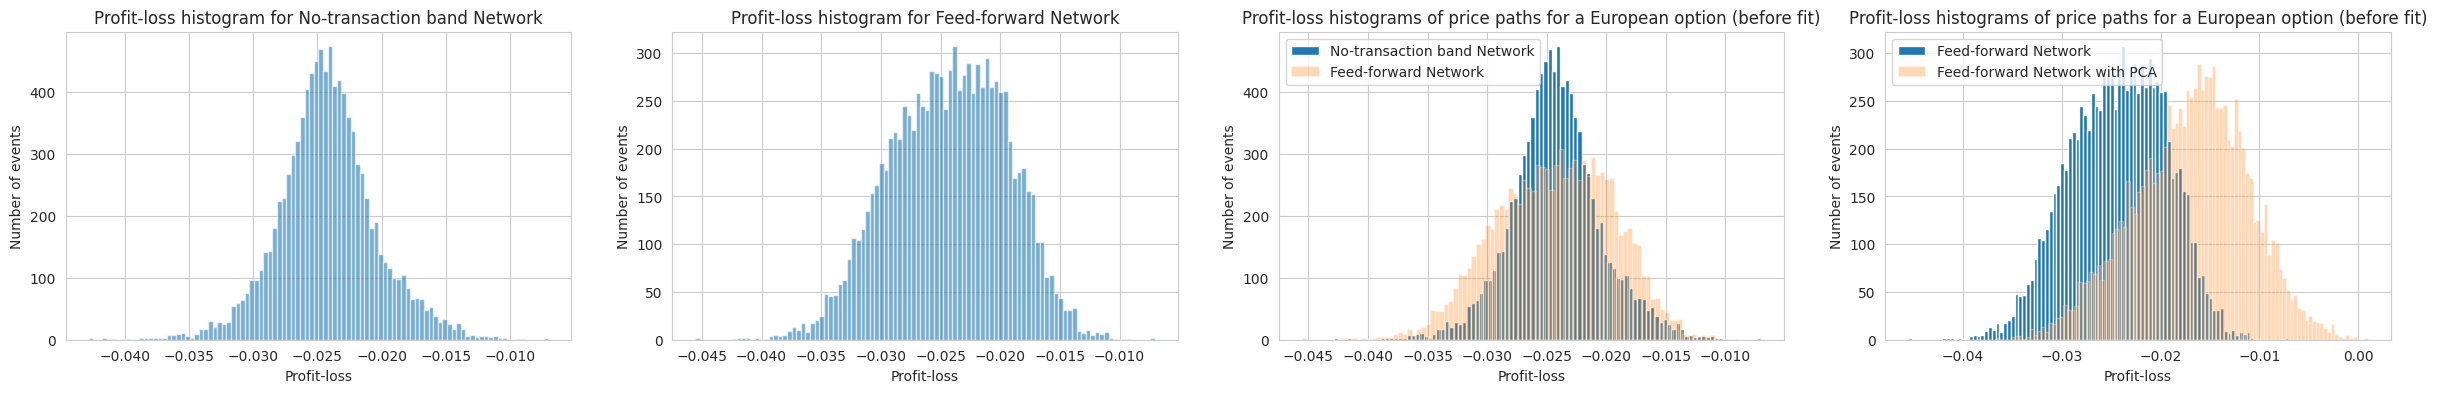

In [41]:
plot()

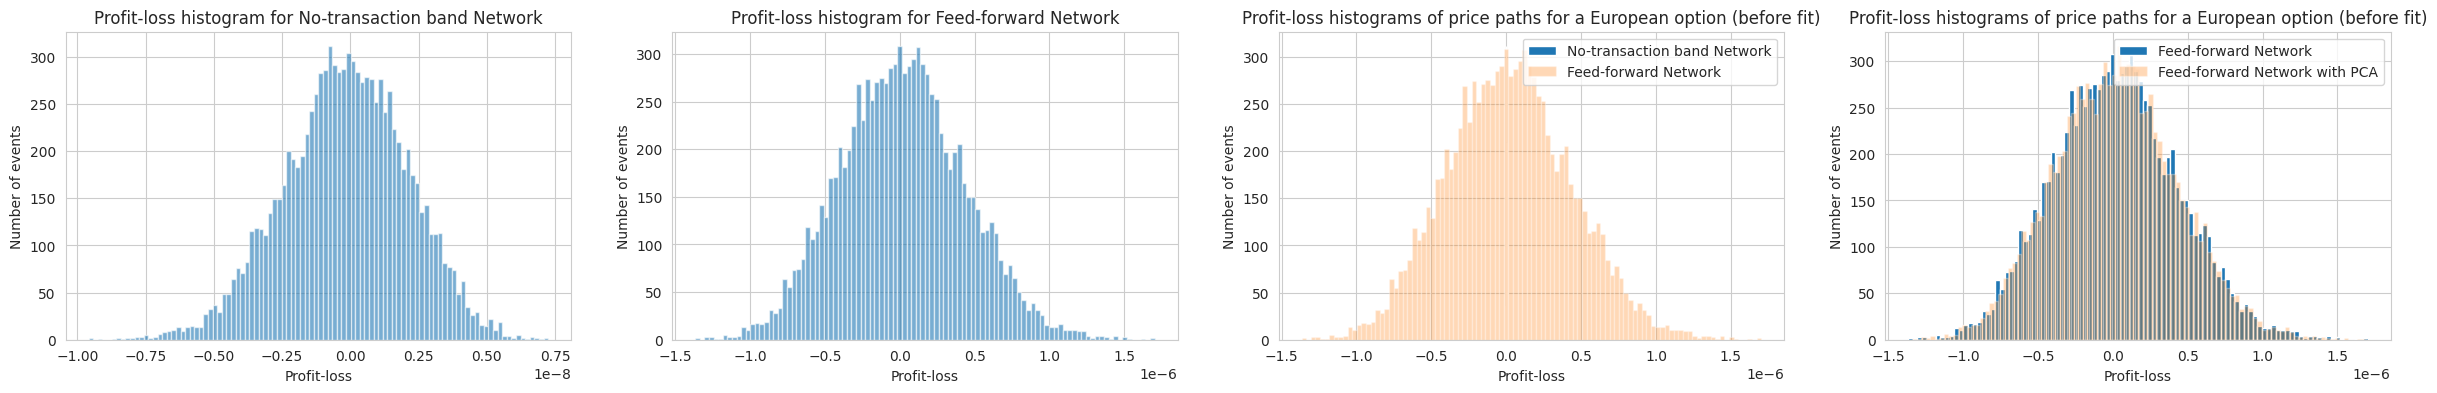

In [42]:
plot("euler")

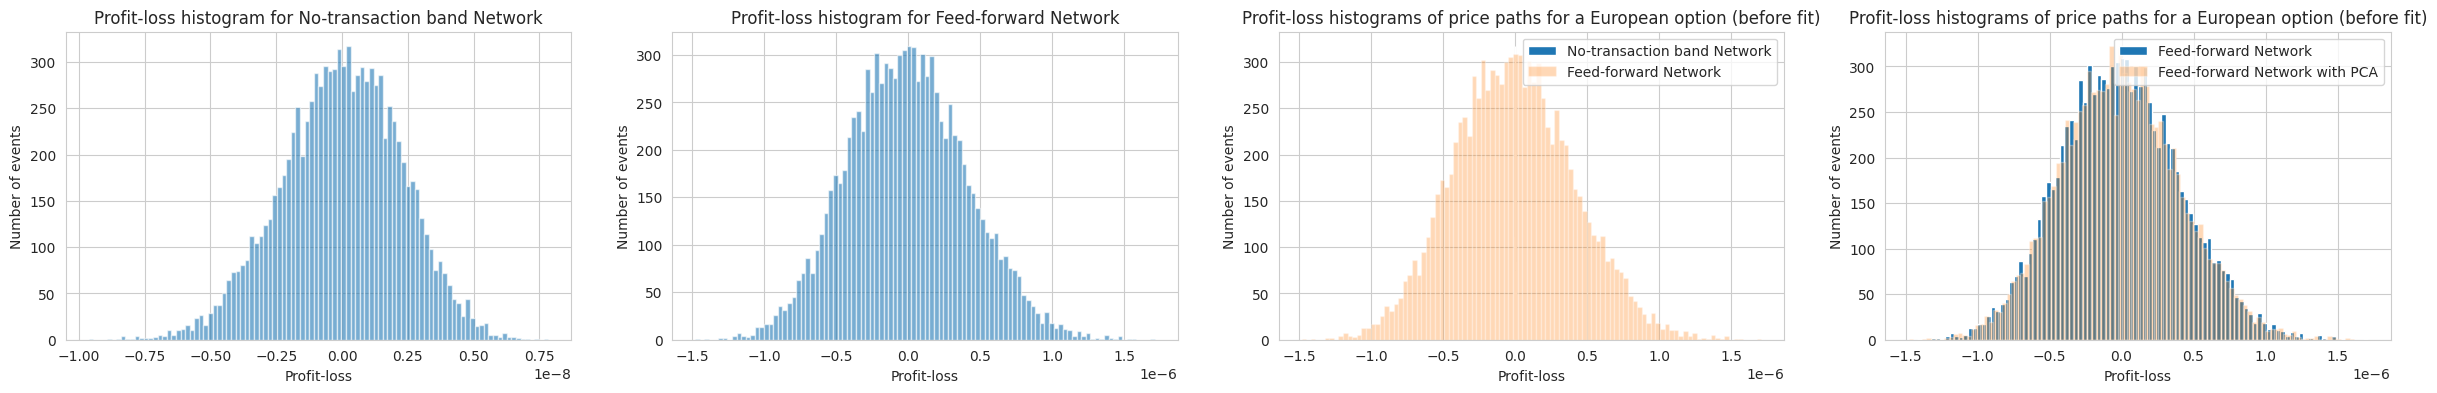

In [43]:
plot("Milstein")

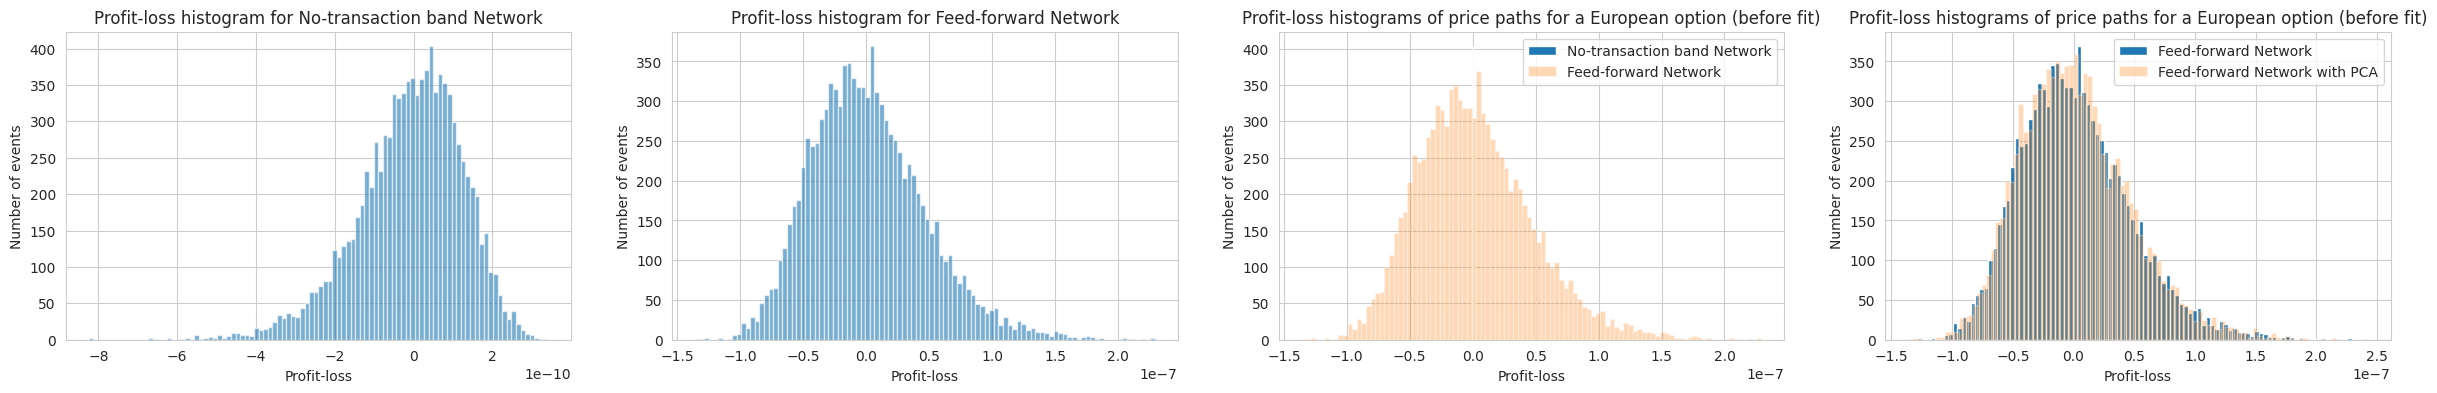

In [46]:
plot("Heston")

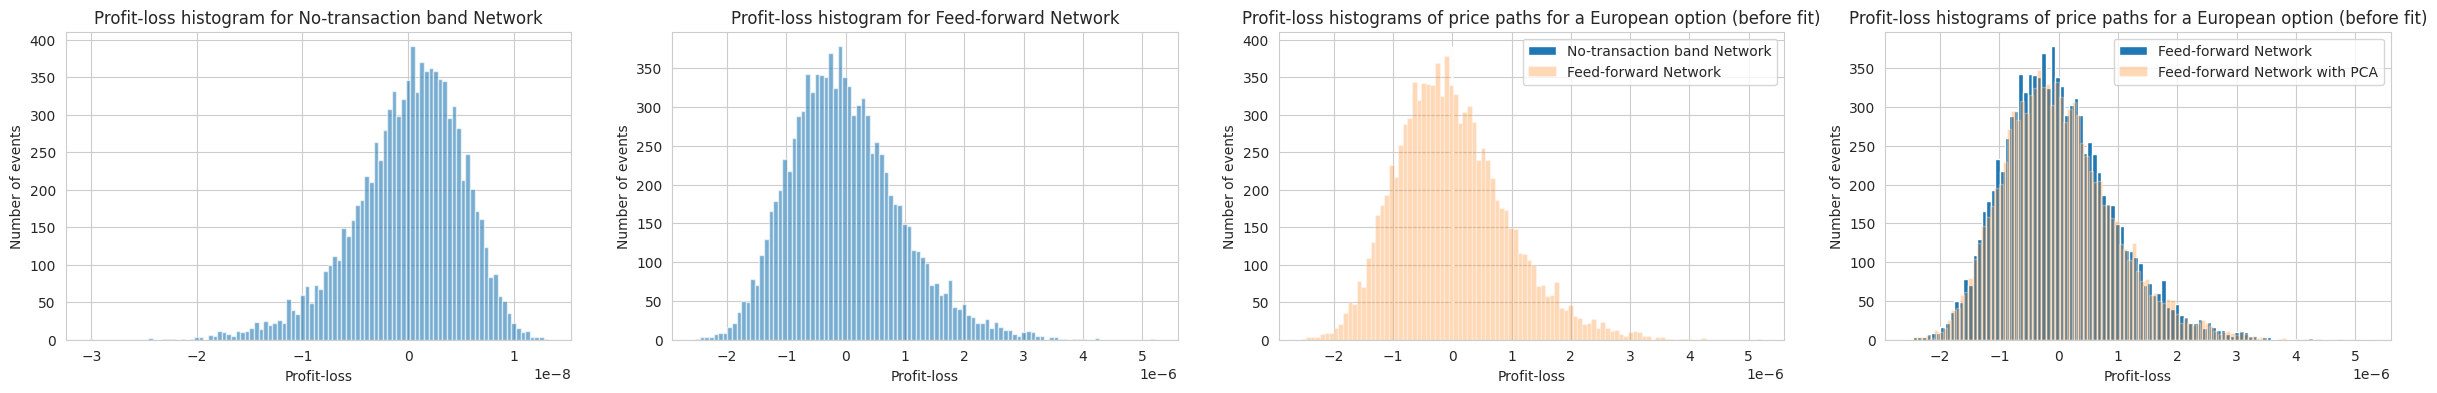

In [39]:
plot("Andersen")

In the article they propose exponential utility $$u(x) = − exp(−λx)$$

In [44]:
from torch.optim import Adam
from tqdm import tqdm


def fit(hedging_model, payoff, cost, n_epochs = N_EPOCHS, lambda_value = 0.1, prog_bar = True):
  
    optim = Adam(hedging_model.parameters())
    optim_pca = Adam(hedging_model.parameters())

    loss_history, loss_history_pca = [], []

    if prog_bar:
        progress = tqdm(range(n_epochs))
    else:
        progress = range(n_epochs)
 
    for _ in progress:
        optim.zero_grad()
        optim_pca.zero_grad()
        pnl, pnl_pca = compute_profit_and_loss(hedging_model, payoff, cost = cost)
        
        loss = torch.mean(-torch.exp(-lambda_value * pnl))
        loss_pca = torch.mean(-torch.exp(-lambda_value * pnl_pca))
        
        loss.backward()
        loss_pca.backward()

        optim.step()
        optim_pca.step()
        if prog_bar:
            progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())
        loss_history_pca.append(loss_pca.item())

    return [loss_history, loss_history_pca]

In [45]:
torch.manual_seed(42)
history_ntb = fit(model_ntb, european_option_payoff, cost = 1e-3)
torch.manual_seed(42)
history_ffn = fit(model_ffn, european_option_payoff, cost = 1e-3)

Loss=-1.00258: 100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


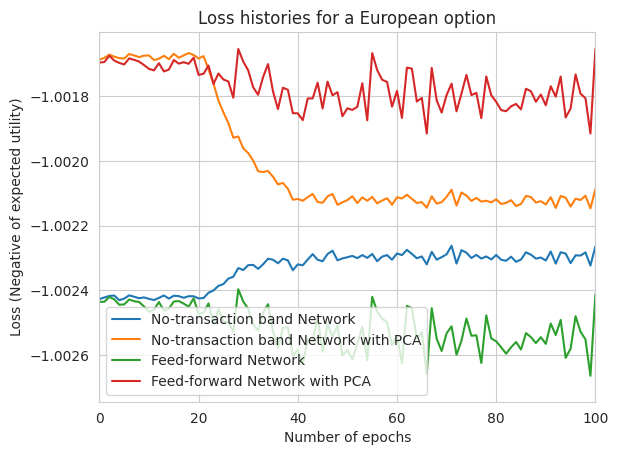

In [46]:
plt.figure()
plt.plot(history_ntb[0], label="No-transaction band Network")
plt.plot(history_ntb[1], label="No-transaction band Network with PCA")
plt.plot(history_ffn[0], label="Feed-forward Network")
plt.plot(history_ffn[1], label="Feed-forward Network with PCA")
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Loss histories for a European option")
plt.xlim([0, 100])
plt.legend()
plt.show()

In [47]:
torch.manual_seed(42)
pnl_ntb, pnl_ntb_pca = compute_profit_and_loss(model_ntb, european_option_payoff, cost=1e-3)
torch.manual_seed(42)
pnl_ffn, pnl_ffn_pca = compute_profit_and_loss(model_ffn, european_option_payoff, cost=1e-3)

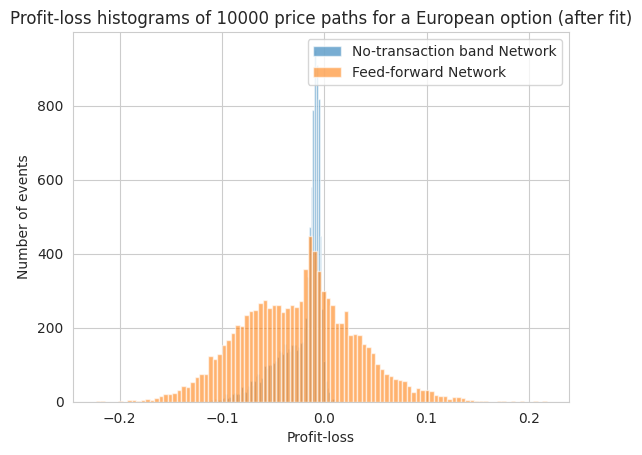

In [48]:
plt.figure()
plt.hist(to_numpy(pnl_ntb), bins=100, alpha=0.6, label="No-transaction band Network")
plt.hist(to_numpy(pnl_ffn), bins=100, alpha=0.6, label="Feed-forward Network")
plt.title(f"Profit-loss histograms of {N_PATHS} price paths for a European option (after fit)")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

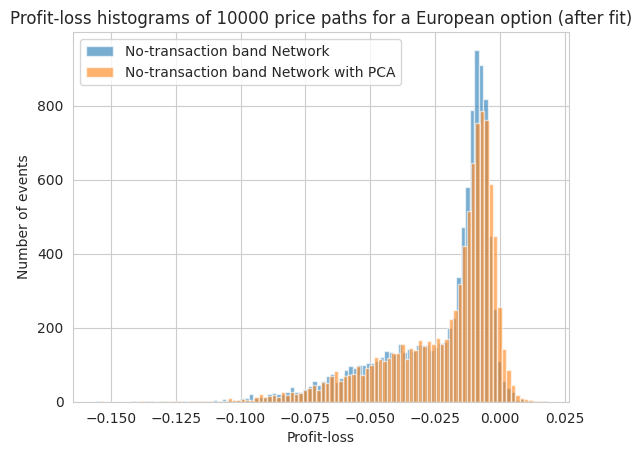

In [49]:
plt.figure()
plt.hist(to_numpy(pnl_ntb), bins=100, alpha=0.6, label="No-transaction band Network")
plt.hist(to_numpy(pnl_ntb_pca), bins=100, alpha=0.6, label="No-transaction band Network with PCA")
plt.title(f"Profit-loss histograms of {N_PATHS} price paths for a European option (after fit)")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

In [50]:
def fit_one_loss(hedging_model, payoff, cost, n_epochs = N_EPOCHS, lambda_value = 0.1, prog_bar = True):
  
    optim = Adam(hedging_model.parameters())
    loss_history = []

    if prog_bar:
        progress = tqdm(range(n_epochs))
    else:
        progress = range(n_epochs)
 
    for _ in progress:
        optim.zero_grad()        
        pnl, pnl_pca = compute_profit_and_loss(hedging_model, payoff, cost = cost)       
        loss = torch.mean(-torch.exp(-lambda_value * pnl))      
        loss.backward()
        optim.step()
        
        if prog_bar:
            progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())
        

    return loss_history

In [52]:
cost_array = np.linspace(1e-4, 1e-2, 5)
loss = []

for _cost in cost_array:
  history_ntb = fit_one_loss(model_ntb, european_option_payoff, cost = _cost, prog_bar = True)
  loss.append(history_ntb[-1])


Loss=-9370681263259648.00000: 100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Something wrong with this plot and the loss above:

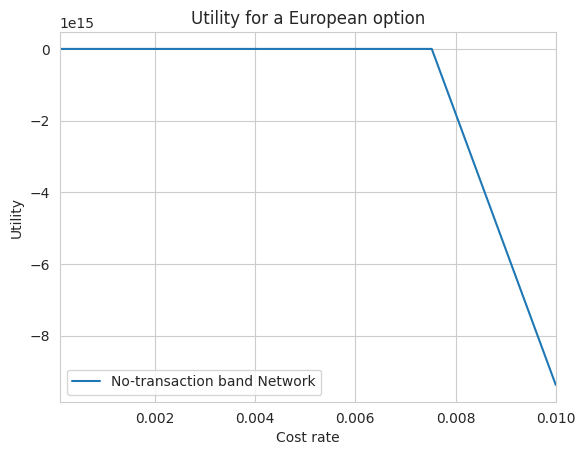

In [53]:
plt.figure()
plt.plot(cost_array, loss, label="No-transaction band Network")

plt.xlabel("Cost rate")
plt.ylabel("Utility")
plt.title("Utility for a European option")
plt.xlim([1e-4, 1e-2])
plt.legend()
plt.show()